Using least squares fit, estimated transition onset time is year 402.00000084016483  and estimated transition duration is 45.672570794141286 years.


C:\Users\JOHATT11\AppData\Local\Temp\ipykernel_9992\3793725449.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


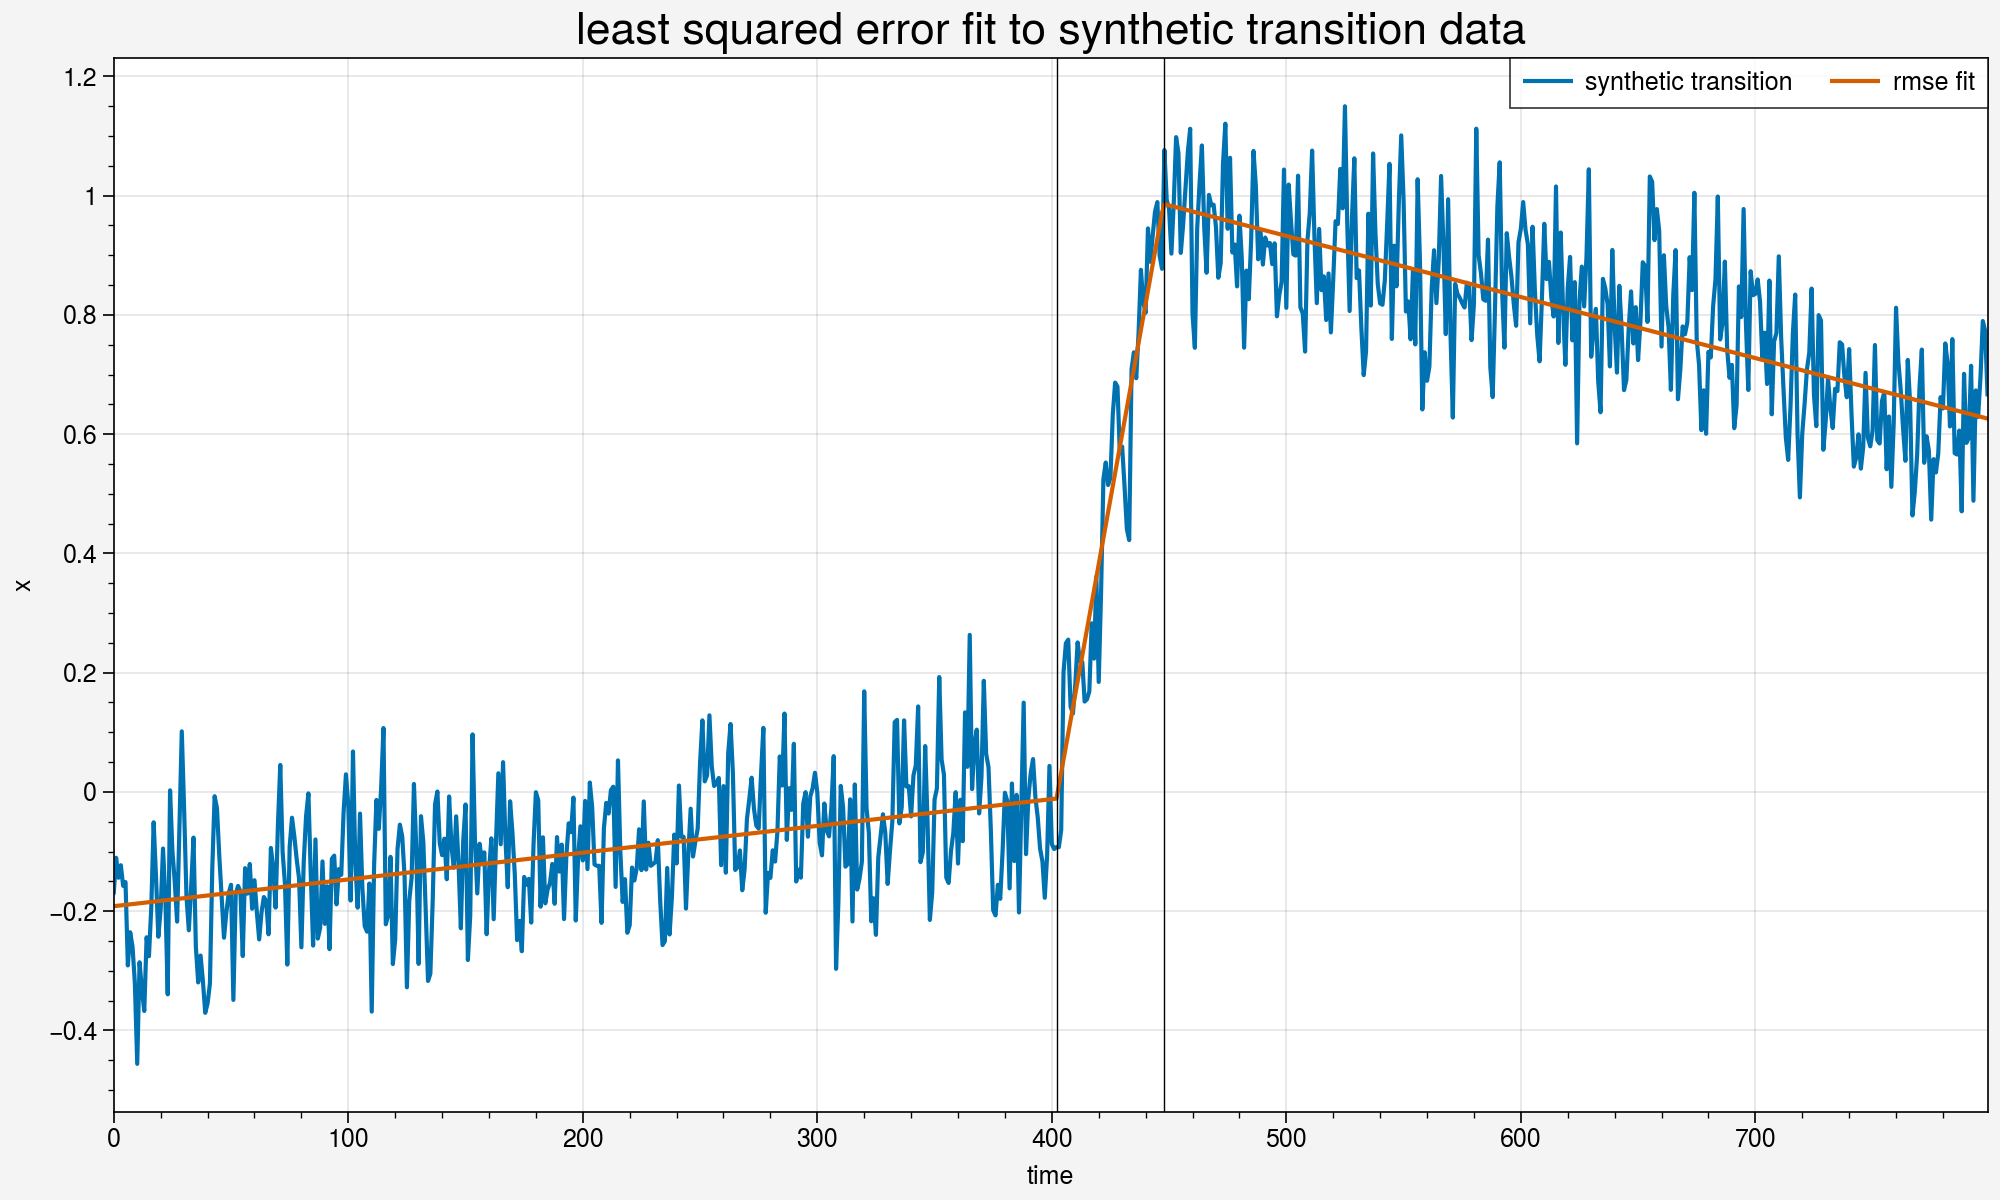

In [3]:
import numpy as np
import proplot as pplt
import pandas as pd
import os
import sys
sys.path.append(os.path.join(sys.path[0],'Updated_Method'))
from model import linear_ramp, fit_rmse
from distributions import sample_ar1
from transition_characterization import estimate_transition, combined_transition
#################################################################
# create synthetic transition                                   #
#################################################################

'''We use the linear ramp function from file model.py and the sample_ar1 function from file
distributions.py to create a synthetic transition which we use to demonstrate the ramp
fitting method.'''

delta = 1.0 #Temporal resolution in years
t0 = 400.0 #Year of transition onset
dt = 50.0 #Transition duration in years
dy = 1.0 #Magnitude of Transition
GS_slope = 5e-4 #Slope during stadial preceding transition in years^-1
GIS_slope = -1e-3 #Slope during interstadial following transition in years^-1
sigma = 0.1 #Variance of AR1 noise
tau = 1.0 #Autocorrelation time of AR1 noise in years

alpha = np.exp(-delta/tau)
time = np.arange(800,step=delta,dtype='float')
trans = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy = 1.0, GS_slope = GS_slope, GIS_slope = GIS_slope)
noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
synt_trans = trans + noise
#################################################################
# least square fit of a linear ramp model to the noisy data     #
#################################################################

'''We first perform a simple least squares fit to this synthetic transition.'''

popt = fit_rmse(time, synt_trans)
cntrl = linear_ramp(time, t0=popt[0], dt=np.exp(popt[1]),
                    y0=popt[2], dy=popt[3], GS_slope=popt[4], GIS_slope=popt[5])
print('Using least squares fit, estimated transition onset time is year \
'+str(popt[0])+'  and estimated \
transition duration is '+str(np.exp(popt[1]))+' years.')

fig = pplt.figure(figsize=(10,6))
ax = fig.add_subplot()
ax.plot(time, synt_trans, color='C0', label='synthetic transition')
ax.plot(time, cntrl, color='C1', label='rmse fit')
ax.axvline(popt[0], color='k', lw=0.5)
ax.axvline(popt[0] + np.exp(popt[1]), color='k', lw=0.5)
ax.set_xlabel('time')
ax.set_ylabel('$x$')
ax.legend()
ax.set_title('least squared error fit to synthetic transition data', fontsize=16)
fig.show()

Using Bayesian fit, mean estimated transition onset time is year 401.9040504035983  and mean estimated transition duration is 45.684541024503204 years.


C:\Users\JOHATT11\AppData\Local\Temp\ipykernel_9992\122845605.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


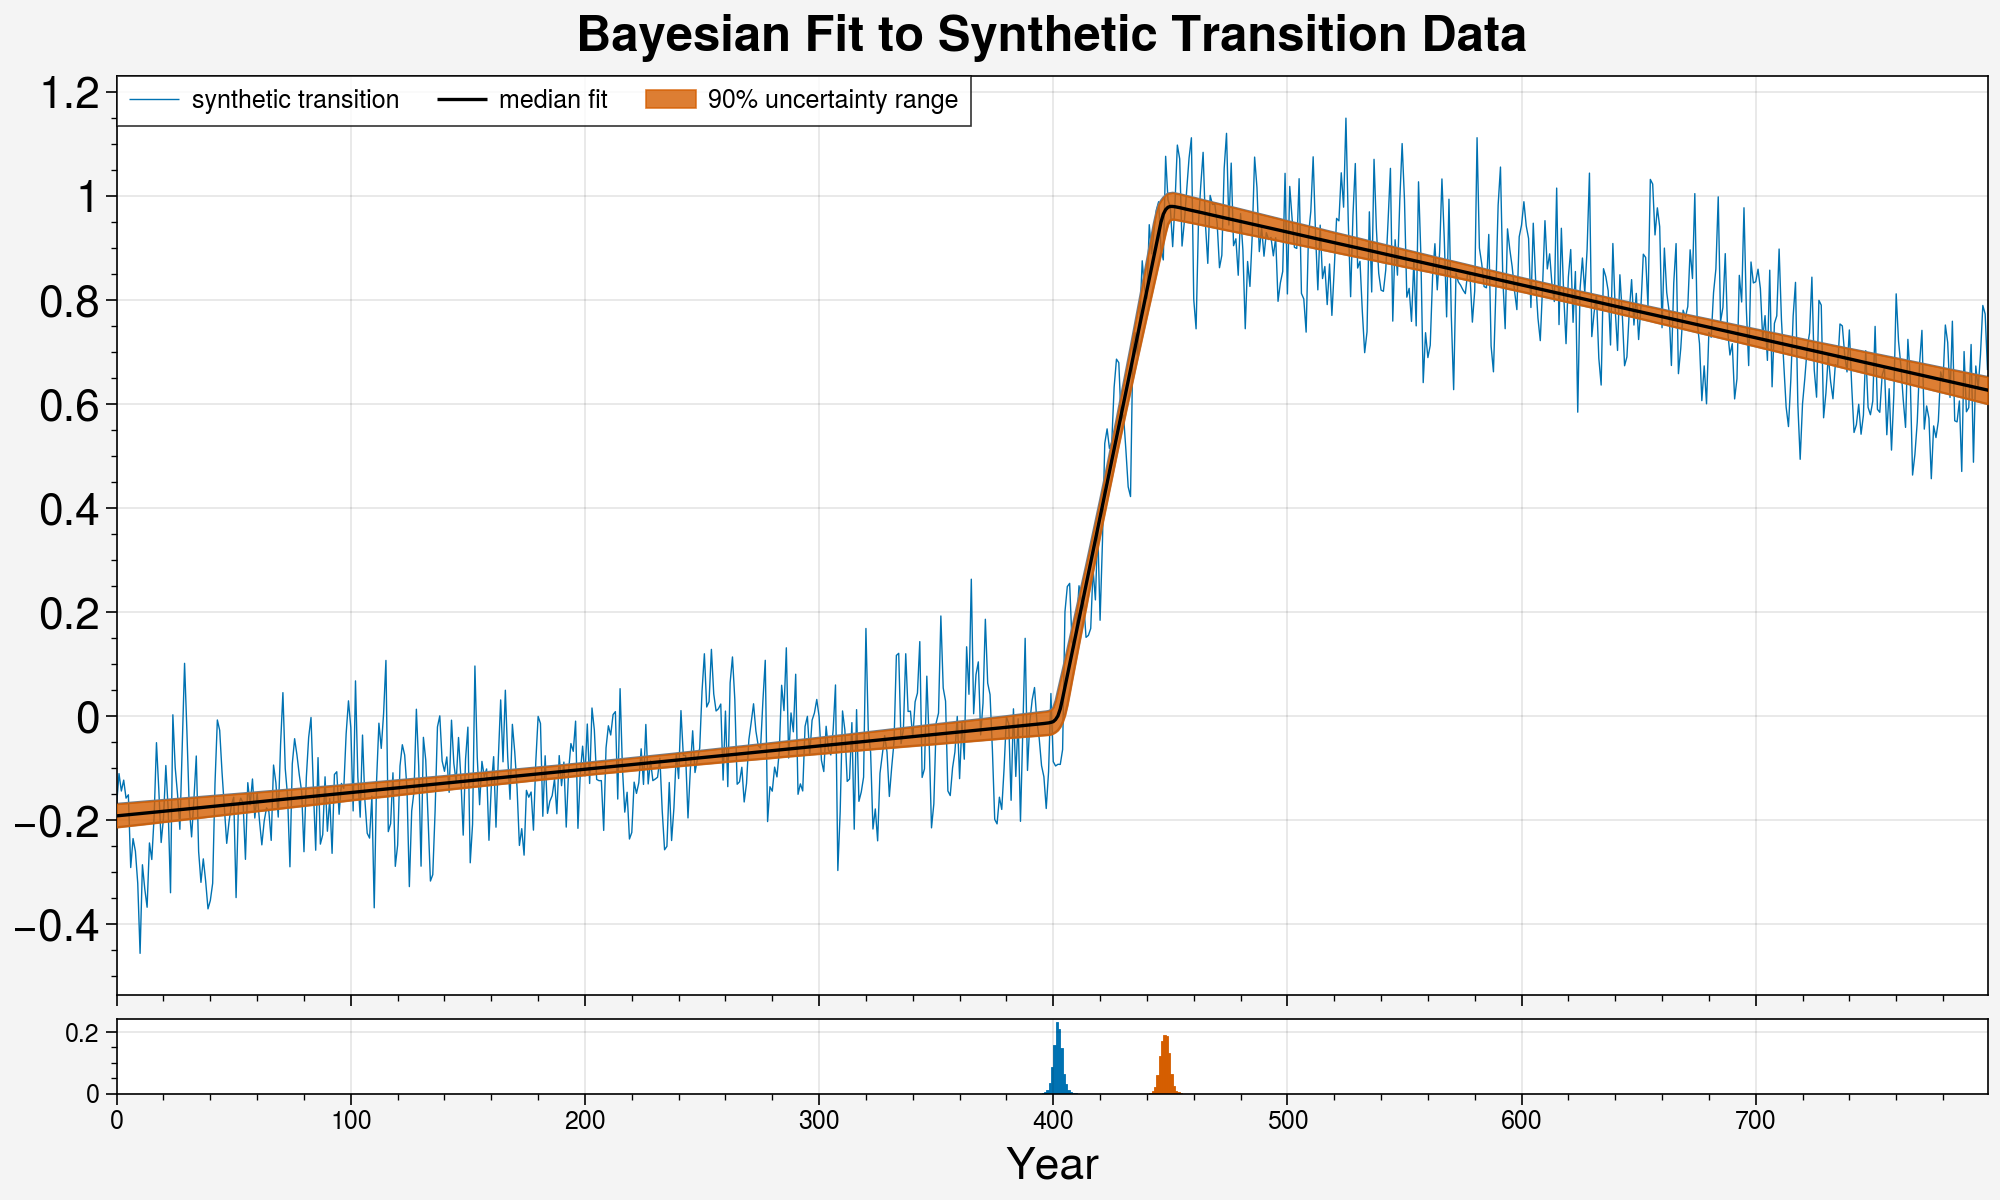

In [4]:
#################################################################
# characterize the transition with the Bayesian linear ramp fit #
# without specification of an initial parameter guess           #
#################################################################

traces, tau = estimate_transition(time, synt_trans, nwalkers=20, nsamples=20000, nthin=200, nburnin=1000, calctau=True)
print('Using Bayesian fit, mean estimated transition onset time is year \
'+str(np.mean(traces['t0']))+'  and mean estimated \
transition duration is '+str(np.mean(traces['dt']))+' years.')

fig = pplt.figure(figsize=(10,6))
ax = fig.add_subplot()

fig.format(xlabel='Year', fontsize=16,
    suptitle='Bayesian Fit to Synthetic Transition Data',
    titleloc='uc', titleabove=False)

p5, p50, p95 = combined_transition(time, traces)


ax.plot(time, synt_trans, lw=0.5, label='synthetic transition')
ax.plot(time, p50, color='k', lw=1.2, label='median fit', zorder=12)
ax.plot(time, p5, color='slategray', lw=0.8)
ax.plot(time, p95, color='slategray',  lw=0.8)
ax.fill_between(x=time, y1=p5, y2=p95, color='C1', alpha=.8, zorder=10, label='90% uncertainty range')

px = ax.panel_axes("b", width='3em', share=True)
px.hist(traces['t0'].values, bins=np.arange(790), density=True, label='onset time')
px.hist(traces['t0'].values + traces['dt'].values, bins=np.arange(790), density=True, label='end time')
ax.legend()
fig.show()